<left><img width=25% src="./slides/img/ucbl-logo-svg-vector.svg"></left>

# TP : Prédiction Insuffisance rénale


In [4]:
#data preprocessing
from datetime import datetime
print(datetime.now())
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import collections
from collections import defaultdict
#import time
from datetime import datetime

#logistic regression model: train and evaluation and XGB 
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from  sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn import metrics
from sklearn.metrics import roc_curve, precision_recall_curve, f1_score, roc_auc_score, auc, accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.impute import SimpleImputer
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
from matplotlib import pyplot as plt
import seaborn as sns




2024-02-25 11:04:31.274669


In [5]:
%matplotlib inline
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
sns.set_style("whitegrid")
sns.set_context("poster")

import bz2
import _pickle as cPickle
# Load any compressed pickle file
def decompress_pickle(file):
 data = bz2.BZ2File(file+'.pbz2', 'rb')
 data = cPickle.load(data)
 return data

## Ensemble de données

On commence par charger les données. Les données représentent les séjours patients (identifiant du séjour: *stay_id*) et une ligne correspond à une découpe du séjour de 6 heures. *time_frame* représente la date de chaque 'tranche' de séjours. La variable *med_stage* représente l'état Insuffisance rénale aigue (IRA). L'absence d'IRA est notée 0 ou NaN et 1,2 ou 3 pour les trois stades respectifs de l'IRA. Cette variable correspond à l'évaluation de la créatinine selon KDIGO. Elle est donc échantillonée toutes les 6 heures et sa valeur peut donc changer. Un patient peut-être dans l'état 1 puis repasser en 0.        

Ici on aggrège par tranche de 6 heures

In [ ]:
SAMPLING_INTERVAL = '6H'
FILL_VALUE = 0 
RESAMPLE_LIMIT = 16 # 4 days*6h interval

print("resampling: MEAN & ZERO")
label = ['med_stage']
skip = ['stay_id', 'time_frame', 'med_stage']

discrete_feat = ['patient_sex']
skip.extend(discrete_feat)    
numeric_feat = list(X.columns.difference(skip))

X = X.set_index('time_frame').groupby('stay_id').resample(SAMPLING_INTERVAL)

X_discrete = X[discrete_feat].max().fillna(FILL_VALUE)
X_numeric = X[numeric_feat].mean() 
X_label = X['med_stage'].max()
print("Merging sampled features")
try:
  X = pd.concat([X_numeric, X_discrete,X_label], axis=1).reset_index()
except:
  X = pd.concat([X_numeric,X_label], axis=1).reset_index()
print(X.shape)
X['med_stage'] = X['med_stage'].ffill(limit=RESAMPLE_LIMIT)

resampling: MEAN & ZERO
Merging sampled features
(335339, 42)


Valeurs manquantes: On choisit de les imputer avec 0. On peut utiliser une autre méthode d'imputation des valeurs manquantes  

In [ ]:

print("Imputation.")
X['med_stage'] = X['med_stage'].fillna(0)
X =  X.fillna(value={'med_stage':'0'})

X = X.fillna(FILL_VALUE) 

Imputation.


Etiquetage des séjours. On fait l'hypothèse qu'un patient est IRA dès le premier stade IRA rencontré.  

In [ ]:
NORMALIZATION = 'min-max' 

CAPPING_THRESHOLD_UPPER = 0.99
CAPPING_THRESHOLD_LOWER = 0.01

def cap_data(df):
    print("Capping between the {} and {} quantile".format(CAPPING_THRESHOLD_LOWER, CAPPING_THRESHOLD_UPPER))
    cap_mask = df.columns.difference(['stay_id', 'time_frame', 'med_stage'])
    df[cap_mask] = df[cap_mask].clip(df[cap_mask].quantile(CAPPING_THRESHOLD_LOWER),
                                     df[cap_mask].quantile(CAPPING_THRESHOLD_UPPER),
                                     axis=1)
    return df

def normalise_data(df, norm_mask):
    print("Normalizing in [0,1] with {} normalization".format(NORMALIZATION))
    
    df[norm_mask] = (df[norm_mask] - df[norm_mask].min()) / (df[norm_mask].max() - df[norm_mask].min())
    
    return df


# Cap features between 0.01 / 0.99 quantile and normalisation

X = cap_data(X)


numeric_feat= X.select_dtypes(include=np.number).columns.tolist()
numeric_feat.remove('stay_id')    

X = normalise_data(X, numeric_feat)

Capping between the 0.01 and 0.99 quantile
Normalizing in [0,1] with min-max normalization


Découpage en apprentissage et test. 

In [ ]:
SPLIT_SIZE = 0.2

print("divide dataset into train, test and validation sets")
id_train, id_test_val = train_test_split(id_list, test_size = SPLIT_SIZE, random_state = 42) # train set is 80%)
# to ensure the same split as LSTM
id_valid, id_test = train_test_split(id_test_val, test_size = 0.5, random_state = 42) # test 10% valid 10%
print(" test is %d" %len(id_test))
id_train = np.concatenate((id_train, id_valid), axis=None)
print("train is %d" % len(id_train))

X_train = X[X.stay_id.isin(id_train)].sort_values(by=['stay_id'])
X_test = X[X.stay_id.isin(id_test)].sort_values(by=['stay_id'], ignore_index = True) 
X_test = X_test.sort_values(by=['stay_id', 'time_frame'], ignore_index = True)
X_train = X_train.sort_values(by=['stay_id', 'time_frame'], ignore_index = True)

X_train = X_train.drop(['time_frame'], axis=1)
X_test = X_test.drop(['time_frame'], axis=1)

label_register =  pd.DataFrame()
label_register['stay_id'] = id_list
label_register['label'] = label_list

y_test = []
id_ordered = X_test['stay_id'].unique()
for i in id_ordered:
    a = label_register.loc[label_register['stay_id']==i].label
    y_test.append(a.values[0])
    
    
y_train = []
id_ordered = X_train['stay_id'].unique()
for i in id_ordered:
    a = label_register.loc[label_register['stay_id']==i].label
    y_train.append(a.values[0])

divide dataset into train, test and validation sets
 test is 725
train is 6522


In [ ]:
#get max shape of 3d array
def get_dimensions(array, level=0):   
    yield level, len(array)
    try:
        for row in array:
            yield from get_dimensions(row, level + 1)
    except TypeError: #not an iterable
        pass

def get_max_shape(array):
    dimensions = defaultdict(int)
    for level, length in get_dimensions(array):
        dimensions[level] = max(dimensions[level], length)
    return [value for _, value in sorted(dimensions.items())]

#pad the ragged 3d array to rectangular shape based on max size
def iterate_nested_array(array, index=()):
    try:
        for idx, row in enumerate(array):
            yield from iterate_nested_array(row, (*index, idx)) 
    except TypeError: # final level            
        yield (*index, slice(len(array))), array # think of the types

def pad(array, fill_value):
    dimensions = get_max_shape(array)
    result = np.full(dimensions, fill_value, dtype = np.float64)  
    for index, value in iterate_nested_array(array):
        result[index] = value 
    return result

In [ ]:
#print("reshape 2D dataframe to 3D Array, group by stay_id")
# one dim = features, one dim number of diff stay_id, one dim for timestamp 
X_train = np.array(list(X_train.groupby(['stay_id'],as_index=False).apply(pd.DataFrame.to_numpy)), dtype=object)
print(X_train.shape)
#print("reshape 2D dataframe to 3D Array, group by stay_id")
X_test = np.array(list(X_test.groupby(['stay_id'],as_index=False).apply(pd.DataFrame.to_numpy)), dtype=object)
print(X_test.shape)

print("fill ragged part(missing value) of 3d array with FILL_VALUE")
dimensions = get_max_shape(X_train)
X_train = pad(X_train, FILL_VALUE)
X_train = X_train[:,:,1:] #delete stay_id
dim_1 = dimensions[1]
dimensions = get_max_shape(X_test)
dimensions[1] = dim_1
result = np.full(dimensions, FILL_VALUE, dtype = np.float64)  
for index, value in iterate_nested_array(X_test):
  result[index] = value 
X_test = result    
X_test = X_test[:,:,1:] #delete stay_id
features = X_train.shape[2]
timestamps = X_train.shape[1]
print("flatten 3D array back to 2D array")
nsamples, nx, ny = X_train.shape
# 13310 133 21 
X_train = X_train.reshape((nsamples,nx*ny))
print(X_train.shape)
nsamples, nx, ny = X_test.shape
X_test = X_test.reshape((nsamples,nx*ny))
print(X_test.shape)

(6522,)
(725,)
fill ragged part(missing value) of 3d array with FILL_VALUE
flatten 3D array back to 2D array
(6522, 8619)
(725, 8619)


## Extrême Gradient Boosting XGBoost



In [ ]:
counter=collections.Counter(y_train)
SCALE_POS_WEIGHT = round(counter[0]/counter[1],1)
    
objective= 'binary:logistic'
print("build GBT")
#build gradient boost model
xgb_model = xgb.XGBClassifier(
learning_rate = 0.1,
n_estimators= 70,
max_depth= 7,
min_child_weight= 3,
gamma= 0.5,
subsample= 0.8,
colsample_bytree= 0.8,
objective= 'binary:logistic',
nthread= 4,
scale_pos_weight= SCALE_POS_WEIGHT,
seed= 42,
early_stopping_rounds= 40,    
eval_metric= ["auc", "error", "logloss"])
        
print("train GBT")
# train xgb
xgb_model.fit(X_train, y_train, 
              eval_set= [(X_test, y_test)],
              verbose= False)


build GBT
train GBT


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, early_stopping_rounds=40,
              enable_categorical=False, eval_metric=['auc', 'error', 'logloss'],
              feature_types=None, gamma=0.5, gpu_id=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=7,
              max_leaves=None, min_child_weight=3, missing=nan,
              monotone_constraints=None, n_estimators=70, n_jobs=None,
              nthread=4, num_parallel_tree=None, predictor=None, ...)

In [ ]:
print("predictions after tuning")
#Make predictions 
GBT_pred = xgb_model.predict(X_test)
GBT_probs = xgb_model.predict_proba(X_test)[::,1]

predictions after tuning


In [ ]:
variables = [
           'med_stage', 
           'lab_phosphate',
           'lab_chloride', 
           'creatinine', 
           'lab_co2', 
           'lab_glucose',
           'pulse',
           'eGRF',
           'lab_calcium', 
           'lab_hemoglobine',
           'lab_potassium', 
           'lab_sodium', 
           'spo2',
           'fr',
           'blood_pressure',
           'temperature', 
           'bmi', 
           'patient_age', 
           'patient_sex',
           'Analgesics',
            'Antibiotics',
            'Anti-cancer drugs',
            'Antiparasitic',
            'Antirheumatic',
            'Antivirals',
            'Immunosuppressants',
            'Hemostasis drugs',
            'Cardiovascular system drugs',
            'Digestive system drugs',
            'Endocrine drugs',
            'Nervous system drugs',
            'hepatopathy', 
            'renal_disease', 
            'renal_transplantation', 
            'infarct_myocardium', 
            'diabete', 
            'vascular_disease', 
            'gout', 
            'cardiac_congestive_insufficiency']

# XGB importance des variables

In [ ]:
# reshape to timestamps x features
xgb_feat = np.reshape(xgb_model.feature_importances_,(timestamps,-1))
# sum the feature importance by feature
xgb_feat = xgb_feat.sum(axis=0)
xgb_feat
xgb_df =  pd.DataFrame(xgb_feat, columns = ['Feature Importance'])
xgb_df['Features'] = variables
#xgb_df = xgb_df.set_index('Features')
xgb_df = xgb_df.sort_values(by = ['Feature Importance'], ascending = False, ignore_index = True)

[]

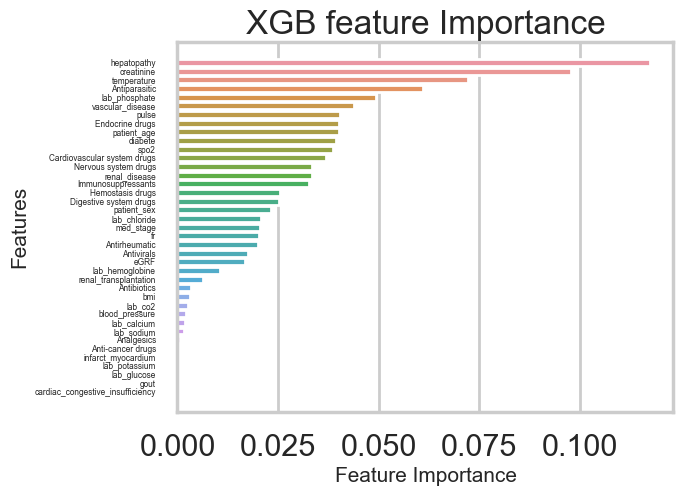

In [ ]:
ax = sns.barplot(x='Feature Importance', y='Features', data=xgb_df)
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 6)
plt.title('XGB feature Importance')
plt.plot()

[]

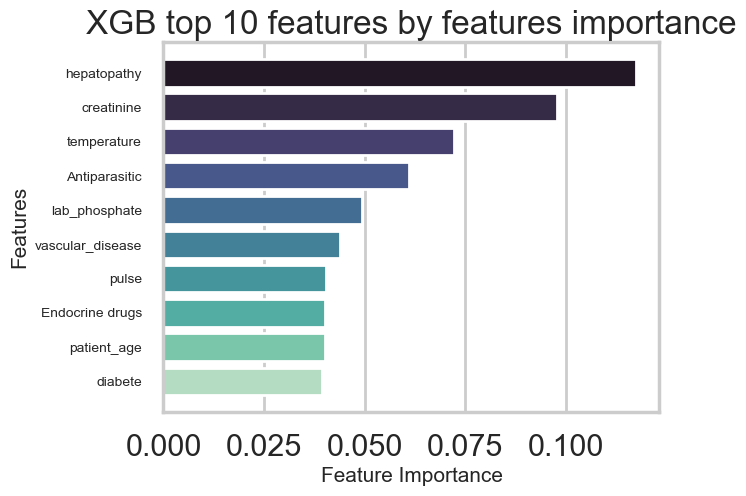

In [ ]:
xgb_df_10 = xgb_df.head(10)
ax = sns.barplot(x='Feature Importance', y='Features', data=xgb_df_10, palette = 'mako')
ax.set_xlabel('Feature Importance', fontsize = 15)
ax.set_ylabel("Features",fontsize=15)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 10)
plt.title('XGB top 10 features by features importance')
plt.plot()

In [ ]:
def performance (y_test, pred_probabilities):
    # performance
    fpr, tpr, thresholds = roc_curve(y_test, pred_probabilities)
    # compute roc auc
    roc_auc = roc_auc_score(y_test, pred_probabilities, average = 'micro')
    # compute Precision_Recall curves
    precision, recall, _ = precision_recall_curve(y_test, pred_probabilities)
    # compute PR_AUC
    pr_auc = metrics.auc(recall, precision)   
    # I add confusion matrix
    optimal_cut_off = round(thresholds[np.argmax(tpr - fpr)],4)
    a = np.where(pred_probabilities > optimal_cut_off, 1, 0)
    brier = round(metrics.brier_score_loss(y_test, pred_probabilities, sample_weight=None, pos_label=None),3)
    predictions = np.where(pred_probabilities > optimal_cut_off, 1, 0)  
    
    print ("Area Under ROC Curve: %0.2f" % roc_auc  )
    print ("Area Under PR Curve(AP): %0.2f" % pr_auc  ) 
    print("Brier score : {:.3f}".format(brier))
    print('Accuracy for Classifier : {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Cut off: ' + str(optimal_cut_off))
    matrix = metrics.confusion_matrix(y_test, a, labels=None, normalize=None)
    print(str(matrix))

In [ ]:
performance (y_test, GBT_probs)

Area Under ROC Curve: 0.94
Area Under PR Curve(AP): 0.93
Brier score : 0.060
Accuracy for Classifier : 0.92
Cut off: 0.4103
[[484  16]
 [ 40 185]]


In [ ]:
def bin_total(y_true, y_prob, n_bins):
    bins = np.linspace(0., 1. + 1e-8, n_bins + 1)
    binids = np.digitize(y_prob, bins) - 1
    return np.bincount(binids, minlength=len(bins))

def missing_bin(bin_array):
    midpoint = " "    
    if bin_array[0]==0:
        midpoint = "5%, "
    if bin_array[1]==0:
        midpoint = midpoint + "15%, "
    if bin_array[2]==0:
        midpoint = midpoint + "25%, "
    if bin_array[3]==0:
        midpoint = midpoint + "35%, " 
    if bin_array[4]==0:
        midpoint = midpoint + "45%, "
    if bin_array[5]==0:
        midpoint = midpoint + "55%, "
    if bin_array[6]==0:
        midpoint = midpoint + "65%, "
    if bin_array[7]==0:
        midpoint = midpoint + "75%, "
    if bin_array[8]==0:
        midpoint = midpoint + "85%, "
    if bin_array[9]==0:
        midpoint = midpoint + "95%, "
    return "The missing bins have midpoint values of "+ str(midpoint)

In [ ]:
def build_graphs (y_test,pred_probabilities, classifier_name, plot_name, algorithm):
    
    # performance
    fpr, tpr, thresholds = roc_curve(y_test, pred_probabilities)
    # compute roc auc
    roc_auc = roc_auc_score(y_test, pred_probabilities, average = 'micro')
    # compute Precision_Recall curves
    precision, recall, _ = precision_recall_curve(y_test, pred_probabilities)
    # compute PR_AUC
    pr_auc = metrics.auc(recall, precision)

    # compute calibration curve
    LR_y, LR_x = calibration_curve(y_test, pred_probabilities, n_bins=10)
    #find out which one are the missing bins
    bin_array = bin_total(y_test, pred_probabilities , n_bins=10)
    print(missing_bin(bin_array))

    print("plot curves and save in one png file")
    #save three plots in one png file
    fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(7, 24))
    fig.subplots_adjust(wspace=0.3, hspace= 0.3)
    fig.suptitle('Evaluation of '+ plot_name)

    fpr, tpr, thresholds = roc_curve(y_test, pred_probabilities)
    
    # plot roc curve
    ax1.plot(fpr, tpr, 'C2', label=algorithm+" "+"Classifier " + str(classifier_name) + ", auc=" +str(round(roc_auc,2)))
    ax1.title.set_text('ROC AUC')
    ax1.set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    ax1.legend(loc="lower right")

    # plot PR curve
    ax2.plot(recall, precision, 'C2', label=algorithm+" "+"Classifier " + str(classifier_name) + ", auc="+str(round(pr_auc,2)))
    ax2.title.set_text('PR AUC')
    ax2.set(xlabel='Recall', ylabel='Precision')
    ax2.legend(loc="lower right")

    # plot calibration curve
    ax3.plot(LR_x, LR_y, 'C2',marker='o', linewidth=1, label='LR')
    line = mlines.Line2D([0, 1], [0, 1], color='black')
    transform = ax3.transAxes
    line.set_transform(transform)
    ax3.add_line(line)
    ax3.title.set_text('Calibration plot for '+str(plot_name))
    ax3.set(xlabel= 'Predicted probability', ylabel= 'True probability in each bin')
    ax3.legend(loc="lower right")

    plt.savefig(plot_name+".png")
    plt.show()
    

The missing bins have midpoint values of  
plot curves and save in one png file


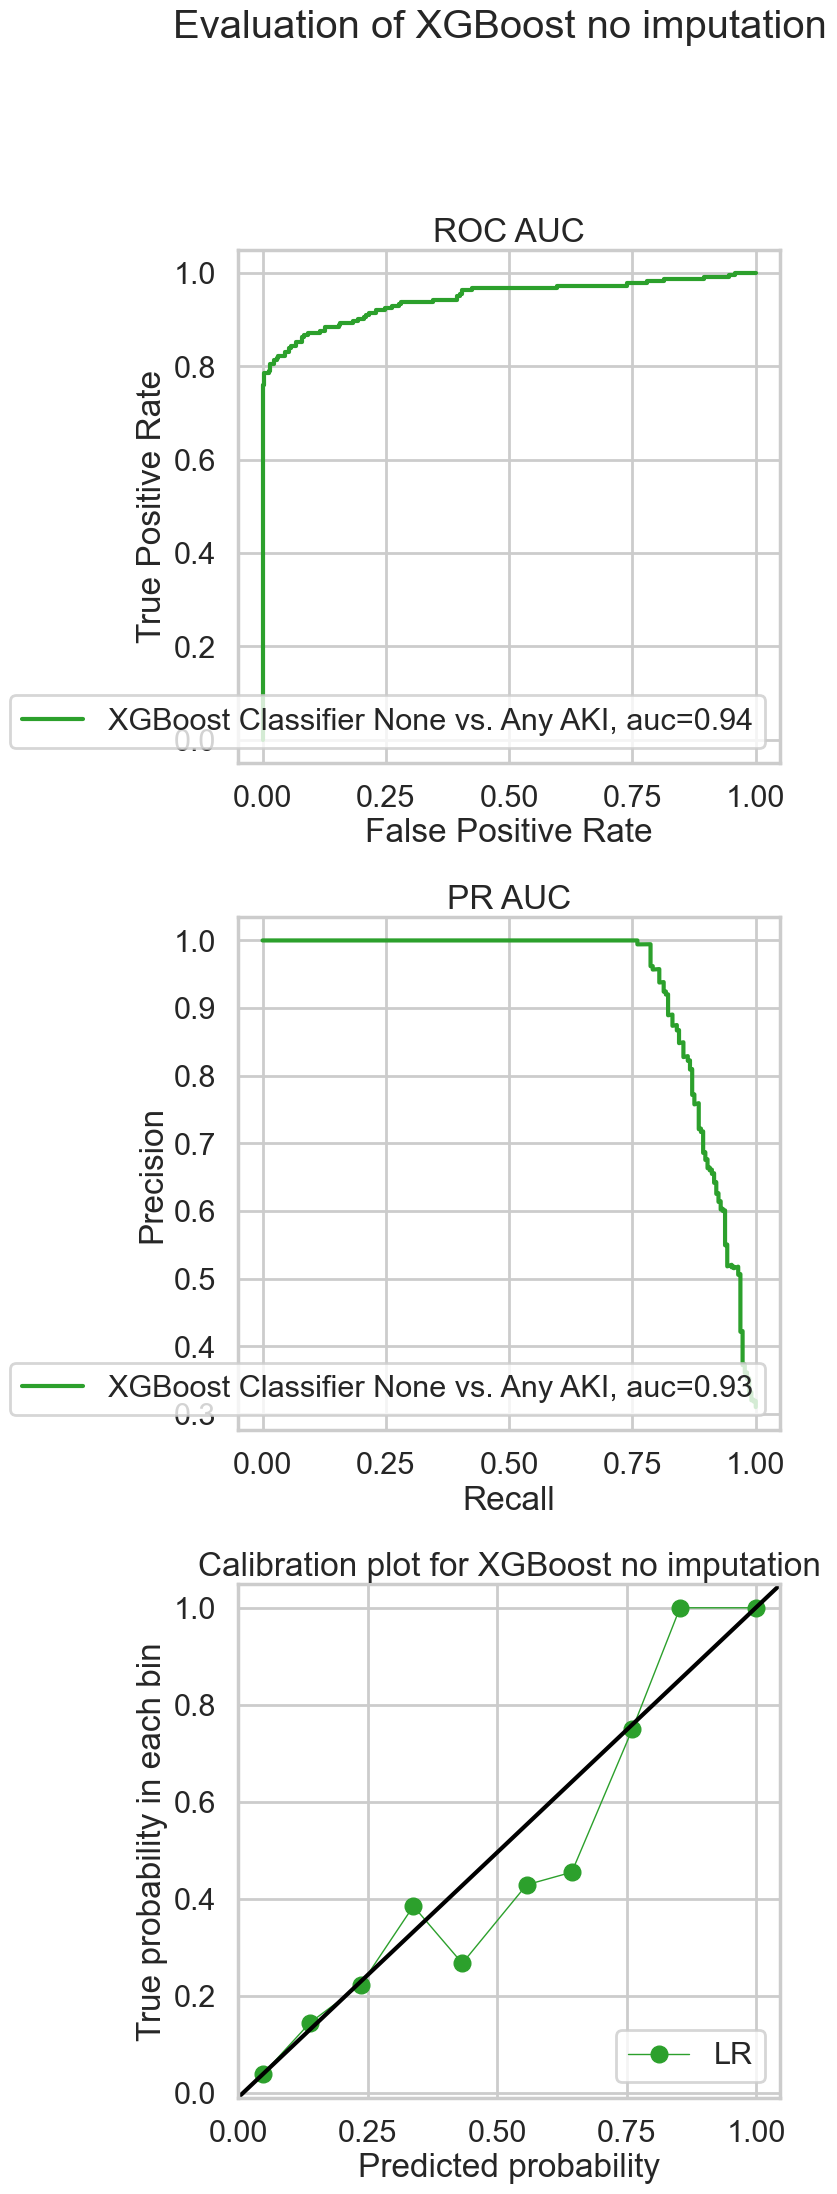

In [ ]:
classifier_name = "None vs. Any AKI"    ###change every time #Moderate vs. Severe #None vs. Any #Others vs. Severe
plot_name = "XGBoost no imputation"
build_graphs(y_test, GBT_probs, classifier_name, plot_name, "XGBoost")

Multiclasses

In [ ]:
filename = 'C:/Users/gic/Downloads/IRADataset.pkl'
X = decompress_pickle(filename)
X.drop('window_start', axis=1, inplace=True)
X.head()

,stay_id,time_frame,inpatient_stay,med_stage,lab_phosphate,lab_chloride,creatinine,lab_co2,lab_glucose,pulse,eGRF,lab_calcium,lab_hemoglobine,lab_potassium,lab_sodium,spo2,fr,blood_pressure,temperature,bmi,patient_age,patient_sex,Analgesics,Antibiotics,Anti-cancer drugs,Antiparasitic,Antirheumatic,Antivirals,Immunosuppressants,Hemostasis drugs,Cardiovascular system drugs,Digestive system drugs,Endocrine drugs,Nervous system drugs,hepatopathy,renal_disease,renal_transplantation,infarct_myocardium,diabete,vascular_disease,gout,cardiac_congestive_insufficiency
13,8311599,2001-01-19 06:00:00,16311599,NaN,0.73,102.0,88.0,29.5,7.5,112.0,79.6701,2.33,172.0,3.9,141.0,93.0,16.0,107.5,36.1,NaN,64.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
14,8311599,2001-01-19 12:00:00,16311599,NaN,0.73,102.0,88.0,29.5,7.5,112.0,79.6701,2.33,172.0,3.9,141.0,93.0,16.0,107.5,36.1,NaN,64.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
15,8311599,2001-01-19 18:00:00,16311599,NaN,0.73,102.0,88.0,29.5,7.5,78.0,79.6701,2.33,172.0,3.9,141.0,98.0,16.0,107.0,36.1,NaN,64.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
16,8311599,2001-01-20 00:00:00,16311599,NaN,0.73,102.0,88.0,29.5,7.5,78.0,79.6701,2.33,172.0,3.9,141.0,98.0,16.0,107.0,36.1,NaN,64.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
17,8311599,2001-01-20 06:00:00,16311599,NaN,29.40,102.0,88.0,29.5,7.5,57.0,79.6701,3.81,172.0,3.9,141.0,98.0,20.0,92.0,36.2,NaN,64.0,M,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN
